# Loading libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel
import xgboost as xg

# Importing the dataset

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Setting main dates

In [ ]:
date = {}
date['date_start_train'] = '2017-04-30' #to avoid some peaks during May and April 2016 and same period of the test.
date['date_end_train'] = '2017-08-15'
date['date_start_test'] = '2017-08-16'
date['date_end_test'] = '2017-08-31'
#test starts on 

diff_test = (pd.Timestamp(date['date_end_test']) - pd.Timestamp(date['date_start_train'])).days
diff_train = (pd.Timestamp(date['date_end_train']) - pd.Timestamp(date['date_start_train'])).days

In [ ]:
# !pip install gluonts
# !pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 19.7 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [ ]:
%matplotlib inline
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as sm
from statsmodels.tsa.stattools import kpss ,  adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gluonts
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.mx.trainer import Trainer
import matplotlib.pyplot  as plt
import pandas as pd
import matplotlib as mpl

from mxnet import gpu

from gluonts.evaluation import Evaluator


/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [ ]:
final_df = pd.read_csv('gdrive/My Drive/df_RF (1).csv', parse_dates=['date'])

In [ ]:
final_df.keys()

Index(['date', 'id', 'store_nbr', 'family', 'sales', 'onpromotion', 'cluster',
       'uniquestore', 'newstore', 'wd', 'firstday', 'isclosed', 'dcoilwtico',
       'lagoil_1_dcoilwtico', 'lagoil_2_dcoilwtico', 'lagoil_3_dcoilwtico',
       'lagoil_4_dcoilwtico', 'lagoil_5_dcoilwtico', 'lagoil_6_dcoilwtico',
       'lagoil_7_dcoilwtico', 'lagoil_10_dcoilwtico', 'lagoil_14_dcoilwtico',
       'oil_week_avg', 'oil_biweek_avg', 'oil_1_month_avg', 'oil_2_month_avg',
       'transactions', 'onpromotion_avg_store', 'onpromotion_std_store', 'day',
       'weekofyear', 'isweekend', 'school_season', 'wageday',
       'earthquake_Aprin2016_effect', 'onpromotion_week_avg',
       'onpromotion_biweek_avg', 'onpromotion_1_month_avg',
       'onpromotion_2_month_avg', 'onpromotion_lag_1', 'onpromotion_lag_2',
       'onpromotion_lag_3', 'onpromotion_lag_4', 'quarter_3', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6', 'store_B', 'store_C', 'store

In [ ]:
final_df.groupby('store_nbr').nunique()
final_df.cluster
final_df['code'] = [str(store)+'_'+str(family) for store,family in zip (final_df['store_nbr'],final_df['family'])]

In [ ]:
final_df = final_df.groupby(['code','date'],as_index = False).sum()

In [ ]:
final_df = final_df.set_index('date')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(final_df['code'])
final_df['code_id'] = le.transform(final_df['code'])

In [ ]:
final_df

,code,id,store_nbr,family,sales,onpromotion,cluster,uniquestore,newstore,wd,...,"sin(2,freq=M)","cos(2,freq=M)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","cos(3,freq=W-SUN)","sin(4,freq=W-SUN)",outliers,code_id
date,,,,,,,,,,,,,,,,,,,,,
2017-04-30,10_0,2808465,10,0,3.0,0,15,0,0,1,...,-0.406737,0.913545,-0.781831,0.623490,-0.974928,-0.222521,-0.900969,0.433884,0,0
2017-05-01,10_0,2810247,10,0,4.0,0,15,0,0,0,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0,0
2017-05-02,10_0,2812029,10,0,0.0,0,15,0,0,1,...,0.394356,0.918958,0.781831,0.623490,0.974928,-0.222521,-0.900969,-0.433884,0,0
2017-05-03,10_0,2813811,10,0,2.0,0,15,0,0,1,...,0.724793,0.688967,0.974928,-0.222521,-0.433884,-0.900969,0.623490,0.781831,0,0
2017-05-04,10_0,2815593,10,0,3.0,0,15,0,0,1,...,0.937752,0.347305,0.433884,-0.900969,-0.781831,0.623490,-0.222521,-0.974928,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,9_9,3022248,9,9,0.0,10,6,0,0,1,...,-0.897805,-0.440394,-0.781831,0.623490,-0.974928,-0.222521,-0.900969,0.433884,0,1781
2017-08-28,9_9,3024030,9,9,0.0,10,6,0,0,1,...,-0.998717,-0.050649,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0,1781
2017-08-29,9_9,3025812,9,9,0.0,9,6,0,0,1,...,-0.937752,0.347305,0.781831,0.623490,0.974928,-0.222521,-0.900969,-0.433884,0,1781


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

def add_header_keys(df, keys, header):
    map_ = {k: header + k for k in keys}
    return df.rename(columns=map_)


def split_dynamic_stat_data(df, keys=None, thresh=0.05):
    if keys is None:
        keys = [k for k in df.keys() if k not in ['sales', 'code', 'ds']]
    dynamic = []
    unique_codes = np.unique(df['code'])
    limit = int(thresh * len(unique_codes))
    counts = {k: [] for k in keys}
    for code in unique_codes:
        code_df = df[df['code'] == code]
        for k in keys:
            if len(np.unique(code_df[k])) > 1:
                #print(
                    #f'For key {k}, code {code} has voted that its dynamical. Unique values are {np.unique(code_df[k])}')
                counts[k].append(code)
                if len(counts[k]) >= limit:
                    #print(f'For key {k}, We have found its dynamical after codes {counts[k]} voted that its dynamical')
                    dynamic.append(k)
                    keys.remove(k)
    static = [k for k in keys]

    return dynamic, static



def split_real_categorical_data(df, thresh=0.1, keys=[], isdynamical=True, auto=False):
    """
    To decide if a variable is categorical or not, we can do the following.
    Take the length of all the values in a series and compare it with the unique values of the series.
    If the unique values is less than 10% of the length of the full series, it means that the variable is categorical.
    Else, the variable is dynamic.
    This nemotecnic rule should work pretty good.
    """

    if len(keys) == 0 and auto:
        keys = [k for k in df.keys() if k not in ['y', 'code', 'ds']]
    elif len(keys) == 0:
        return [], []

    if isdynamical:
        """
        this will not work for statical data... but it is the most pure way to do it.
        """
        votes = {k: 0 for k in keys}
        for code in np.unique(df['code']):
            code_df = df[df['code'] == code]
            for k in keys:
                if len(code_df[k]) > 1:
                    if len(np.unique(code_df[k])) < thresh * len(code_df[k]) or len(np.unique(code_df[k])) == 1:
                        votes[k] -= 1
                    else:
                        votes[k] += 1.5

        categorical = []
        real = []
        for k in votes.keys():
            if votes[k] >= 0:
                real.append(k)
            else:
                categorical.append(k)

    else:
        categorical = []
        for k in keys:
            if len(np.unique(df[k])) < thresh * len(df):
                categorical.append(k)
                keys.remove(k)
        real = keys

    print(f'Real keys before formatting {real}')
    print(f'Categorical keys before formatting {categorical}')
    print()
    for k in real:
        if isinstance(np.array(df[k])[0], str):
            categorical.append(k)
            real.remove(k)
    for k in categorical:
        if isinstance(np.array(df[k])[0], float):
            real.append(k)
            categorical.remove(k)
    print(f'Real keys after formatting {real}')
    print(f'Categorical keys after formatting {categorical}')
    return categorical, real



def split_features(df, thresh=0.1):
    dyn, stat = split_dynamic_stat_data(df)
    dyn_cat, dyn_re = split_real_categorical_data(df, thresh=thresh, keys=dyn)
    stat_cat, stat_re = split_real_categorical_data(df, thresh=thresh, keys=stat)
    return dyn_cat, dyn_re, stat_cat, stat_re

def generate_labelled_exogenous_df(df, one_hot=True, thresh=0.1,ignore_keys = [['code','sales']]):
    dyn_cat, dyn_re, stat_cat, stat_re = split_features(df, thresh=thresh)
    print('Dynamical categorical features:')
    for k in dyn_cat:
        print(k)
    print('\n\n')
    print('Dynamical real features:')
    for k in dyn_re:
        print(k)
    print('\n\n')
    print('Statical categorical features:')
    for k in stat_cat:
        print(k)
    print('\n\n')
    print('Statical real features:')
    for k in stat_re:
        print(k)
    print('\n\n')
    new_df = df.copy()
    new_df = add_header_keys(new_df, dyn_cat, 'dyn_cat_')
    new_df = add_header_keys(new_df, dyn_re, 'dyn_re_')
    new_df = add_header_keys(new_df, stat_cat, 'stat_cat_')
    new_df = add_header_keys(new_df, stat_re, 'stat_re_')

    ordinal_encoder = None

    if one_hot:
        cat_dyn_keys = [k for k in new_df.keys() if 'dyn_cat_' in k]
        for k in cat_dyn_keys:
            tmp = pd.get_dummies(new_df[k], prefix=k)
            for new_k in tmp.keys():
                new_k_re = new_k.replace('dyn_cat_', 'dyn_re_OneHot_')
                new_df[new_k_re] = tmp[new_k].copy()
        new_df = new_df.drop(cat_dyn_keys, axis=1)

        cat_sat_keys = [k for k in new_df.keys() if 'stat_cat_' in k]
        features = new_df[cat_sat_keys].to_numpy()
        ordinal_encoder = OrdinalEncoder().fit(features)
        encoded_features = ordinal_encoder.transform(features)
        for i, k in enumerate(cat_sat_keys):
            new_df[k] = encoded_features[:, i]

    return new_df, ordinal_encoder

In [ ]:
dd, encod = generate_labelled_exogenous_df(final_df, one_hot = False)

Real keys before formatting ['id', 'dcoilwtico', 'lagoil_2_dcoilwtico', 'lagoil_4_dcoilwtico', 'lagoil_6_dcoilwtico', 'lagoil_10_dcoilwtico', 'oil_week_avg', 'oil_1_month_avg', 'transactions', 'onpromotion_std_store', 'weekofyear', 'onpromotion_week_avg', 'onpromotion_1_month_avg', 'trend', 'cos(1,freq=A-DEC)', 'cos(2,freq=A-DEC)', 'cos(3,freq=A-DEC)', 'cos(4,freq=A-DEC)', 'cos(5,freq=A-DEC)', 'cos(1,freq=M)', 'cos(2,freq=M)', 'lagoil_1_dcoilwtico', 'lagoil_5_dcoilwtico', 'lagoil_14_dcoilwtico', 'oil_2_month_avg', 'day', 'onpromotion_biweek_avg', 'sin(1,freq=A-DEC)', 'sin(3,freq=A-DEC)', 'sin(5,freq=A-DEC)', 'sin(2,freq=M)', 'lagoil_3_dcoilwtico', 'oil_biweek_avg', 'onpromotion_2_month_avg', 'sin(2,freq=A-DEC)', 'sin(1,freq=M)', 'lagoil_7_dcoilwtico', 'sin(4,freq=A-DEC)', 'onpromotion_avg_store']
Categorical keys before formatting ['wd', 'school_season', 'quarter_3', 'dayofweek_2', 'dayofweek_4', 'dayofweek_6', 'cos(1,freq=W-SUN)', 'cos(2,freq=W-SUN)', 'sin(4,freq=W-SUN)', 'wageday', '

In [ ]:
cols_dyn_re = dd.columns[dd.columns.str.match(r'dyn_re')]
cols_stat_cat = dd.columns[dd.columns.str.match(r'stat_cat')]
cols_dyn_cat = dd.columns[dd.columns.str.match(r'dyn_cat')]
cols_stat_re = dd.columns[dd.columns.str.match(r'stat_re')]

In [ ]:
len(cols_dyn_re),len(cols_stat_cat),len(cols_dyn_cat),len(cols_stat_re)

(45, 14, 16, 0)

In [ ]:
cols_dyn_re = cols_dyn_re.tolist() + cols_dyn_cat.tolist()

In [ ]:
dd.keys()

Index(['code', 'dyn_re_id', 'stat_cat_store_nbr', 'stat_cat_family', 'sales',
       'dyn_cat_onpromotion', 'stat_cat_cluster', 'stat_cat_uniquestore',
       'stat_cat_newstore', 'dyn_cat_wd', 'stat_cat_firstday',
       'stat_cat_isclosed', 'dyn_re_dcoilwtico', 'dyn_re_lagoil_1_dcoilwtico',
       'dyn_re_lagoil_2_dcoilwtico', 'dyn_re_lagoil_3_dcoilwtico',
       'dyn_re_lagoil_4_dcoilwtico', 'dyn_re_lagoil_5_dcoilwtico',
       'dyn_re_lagoil_6_dcoilwtico', 'dyn_re_lagoil_7_dcoilwtico',
       'dyn_re_lagoil_10_dcoilwtico', 'dyn_re_lagoil_14_dcoilwtico',
       'dyn_re_oil_week_avg', 'dyn_re_oil_biweek_avg',
       'dyn_re_oil_1_month_avg', 'dyn_re_oil_2_month_avg',
       'dyn_re_transactions', 'dyn_re_onpromotion_avg_store',
       'dyn_re_onpromotion_std_store', 'dyn_re_day', 'dyn_re_weekofyear',
       'dyn_cat_isweekend', 'dyn_cat_school_season', 'dyn_cat_wageday',
       'stat_cat_earthquake_Aprin2016_effect', 'dyn_re_onpromotion_week_avg',
       'dyn_re_onpromotion_biweek_av

In [ ]:
dd

,code,dyn_re_id,stat_cat_store_nbr,stat_cat_family,sales,dyn_cat_onpromotion,stat_cat_cluster,stat_cat_uniquestore,stat_cat_newstore,dyn_cat_wd,...,"dyn_re_sin(2,freq=M)","dyn_re_cos(2,freq=M)","dyn_cat_sin(1,freq=W-SUN)","dyn_re_cos(1,freq=W-SUN)","dyn_re_sin(2,freq=W-SUN)","dyn_cat_cos(2,freq=W-SUN)","dyn_re_cos(3,freq=W-SUN)","dyn_re_sin(4,freq=W-SUN)",stat_cat_outliers,stat_cat_code_id
date,,,,,,,,,,,,,,,,,,,,,
2017-04-30,10_0,2808465,10,0,3.0,0,15,0,0,1,...,-0.406737,0.913545,-0.781831,0.623490,-0.974928,-0.222521,-0.900969,0.433884,0,0
2017-05-01,10_0,2810247,10,0,4.0,0,15,0,0,0,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0,0
2017-05-02,10_0,2812029,10,0,0.0,0,15,0,0,1,...,0.394356,0.918958,0.781831,0.623490,0.974928,-0.222521,-0.900969,-0.433884,0,0
2017-05-03,10_0,2813811,10,0,2.0,0,15,0,0,1,...,0.724793,0.688967,0.974928,-0.222521,-0.433884,-0.900969,0.623490,0.781831,0,0
2017-05-04,10_0,2815593,10,0,3.0,0,15,0,0,1,...,0.937752,0.347305,0.433884,-0.900969,-0.781831,0.623490,-0.222521,-0.974928,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,9_9,3022248,9,9,0.0,10,6,0,0,1,...,-0.897805,-0.440394,-0.781831,0.623490,-0.974928,-0.222521,-0.900969,0.433884,0,1781
2017-08-28,9_9,3024030,9,9,0.0,10,6,0,0,1,...,-0.998717,-0.050649,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0,1781
2017-08-29,9_9,3025812,9,9,0.0,9,6,0,0,1,...,-0.937752,0.347305,0.781831,0.623490,0.974928,-0.222521,-0.900969,-0.433884,0,1781


In [ ]:
prov = dd['2017-08-16':date['date_end_test']]
prov = prov.reset_index()
prov = prov.groupby(['date', 'stat_cat_store_nbr',	'stat_cat_family'])
prov.first(
)

code  dyn_re_id  sales  \
date       stat_cat_store_nbr stat_cat_family                            
2017-08-16 1                  0                  1_0    3000888    0.0   
                              1                  1_1    3000889    0.0   
                              2                  1_2    3000890    0.0   
                              3                  1_3    3000891    0.0   
                              4                  1_4    3000892    0.0   
...                                              ...        ...    ...   
2017-08-31 54                 28               54_28    3029263    0.0   
                              29               54_29    3029264    0.0   
                              30               54_30    3029265    0.0   
                              31               54_31    3029266    0.0   
                              32               54_32    3029267    0.0   

                                               dyn_cat_onpromotion  \
date       stat_cat_store_nbr stat_cat_family                        
2017-08-16 1                  0                                  0   
                              1                                  0   
                              2                                  2   
                              3                                 20   
                              4                                  0   
...                                                            ...   
2017-08-31 54                 28                                 0   
                              29                                 0   
                              30                                 1   
                              31                                 0   
                              32                                 0   

                                               stat_cat_cluster  \
date       stat_cat_store_nbr stat_cat_family                     
2017-08-16 1                  0                              13   
                              1                              13   
                              2                              13   
                              3                              13   
                              4                              13   
...                                                         ...   
2017-08-31 54                 28                              3   
                              29                              3   
                              30                              3   
                              31                              3   
                              32                              3   

                                               stat_cat_uniquestore  \
date       stat_cat_store_nbr stat_cat_family                         
2017-08-16 1                  0                                   0   
                              1                                   0   
                              2                                   0   
                              3                                   0   
                              4                                   0   
...                                                             ...   
2017-08-31 54                 28                                  1   
                              29                                  1   
                              30                                  1   
                              31                                  1   
                              32                                  1   

                                               stat_cat_newstore  dyn_cat_wd  \
date       stat_cat_store_nbr stat_cat_family                                  
2017-08-16 1                  0                                0           1   
                              1                                0           1   
                              2                           

In [ ]:

class DeepAR() : 
  def __init__(self,df) : 

    """ 
    init (self,df) : the constructor of the class

    """
    self.df = df

  def prepare_dataset(self,start_index,target_index,target,freq):
    dataset = ListDataset([{"start": start_index, 
                                        "target": self.df[target][start_index:target_index]}], freq = freq)
    return dataset

  def prepare_dataset_grouped(self,start_index,target_index,target,freq, dyn_re_list, stat_cat_list, groupby_index = 'stat_cat_code_id'):
    dataset_list = []
    counter = 0
    total = len(self.df[groupby_index].unique())
    for item_id,df_item in self.df.groupby(groupby_index,as_index = False):
      counter+=1
      if counter%200==0:
        print (f'{counter}/{total}')
      current_dataset = {"start": start_index, 
                                        "target": df_item[target][start_index:target_index]}
      
      dynre_list = []
      statcat_list = []

      for dyn_re in dyn_re_list:
        dynre_list.append(df_item[dyn_re][start_index:target_index])

      for stat_cat in stat_cat_list:
        statcat_list.append(df_item[stat_cat].iloc[0])

      
      current_dataset[FieldName.FEAT_STATIC_CAT] = statcat_list
      current_dataset[FieldName.FEAT_DYNAMIC_REAL] = dynre_list

      dataset_list.append(current_dataset)
      

                                        
    dataset = ListDataset(dataset_list, freq = freq)
    return dataset  


  def prepare_train (self,start_index,target_index,target, freq, dyn_re_list, stat_cat_list) : 
    
     """ 
     To prepare the train data from a start_index and target index
     """
     self.training_data = self.prepare_dataset_grouped(start_index,target_index,target,freq, dyn_re_list, stat_cat_list)

  def prepare_test (self,start_index,target_index,target,freq, dyn_re_list, stat_cat_list) : 
    
    self.test_data = self.prepare_dataset_grouped(start_index,target_index,target,freq, dyn_re_list, stat_cat_list)

  def estimator (self,freq,context_length,prediction_length,num_layers,num_cells,cell_type,epochs,cardinality, use_external = True) : 

    """"
    In order to fix the architecture of the estimator .. num_layers , cell_type etc ...
    
    """

    self.estimator = DeepAREstimator(freq=freq, 
                            context_length=context_length,  
                            prediction_length=prediction_length,
                            num_layers=num_layers,    
                            num_cells=num_cells,
                            cell_type=cell_type,
                            #trainer=Trainer(epochs=epochs,ctx=gpu())) 
                            trainer=Trainer(epochs=epochs),
                            use_feat_dynamic_real=True*use_external,
                            use_feat_static_cat=True*use_external,
                            use_feat_static_real=False*use_external,
                            distr_output = NegativeBinomialOutput(),
                            cardinality = cardinality) 

    self.prediction_length = prediction_length

  def train(self) : 

    """
    to do the fit
    
    """
    self.predictor = self.estimator.train(training_data=self.training_data)

  def evaluate (self,num_samples=100) : 

    """ 
    to do evaluation task

    """
    forecast_it, ts_it = make_evaluation_predictions(
    dataset=self.test_data,  
    predictor=self.predictor,   
    num_samples=num_samples, 
    )
    self.forecasts1 = forecast_it
    self.forecasts = list(forecast_it)
    self.tss =  list(ts_it)

    
  def plot_prob_forecasts(self, index):

    """
    plot the forecasts
    
    """
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    self.tss[index].plot(ax=ax) 
    self.forecasts[index].plot(color='g')
    #self.forecasts[index].plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
         

In [ ]:
deepar = DeepAR(dd)
deepar.prepare_train(date['date_start_train'],date['date_end_train'],'sales','d', cols_dyn_re, cols_stat_cat)
cardinality = np.array(dd[cols_stat_cat].max()+1)

200/1782
400/1782
600/1782
800/1782
1000/1782
1200/1782
1400/1782
1600/1782


In [ ]:
deepar.estimator(freq = 'd',context_length = 60, prediction_length = 16,num_layers = 2, num_cells = 40,cell_type = "gru",epochs = 50,cardinality = cardinality.tolist())
deepar.train()

100%|██████████| 50/50 [00:08<00:00,  5.60it/s, epoch=50/50, avg_epoch_loss=4.51]


In [ ]:
date['date_start_test'] = '2017-04-30'

200/1782
400/1782
600/1782
800/1782
1000/1782
1200/1782
1400/1782
1600/1782


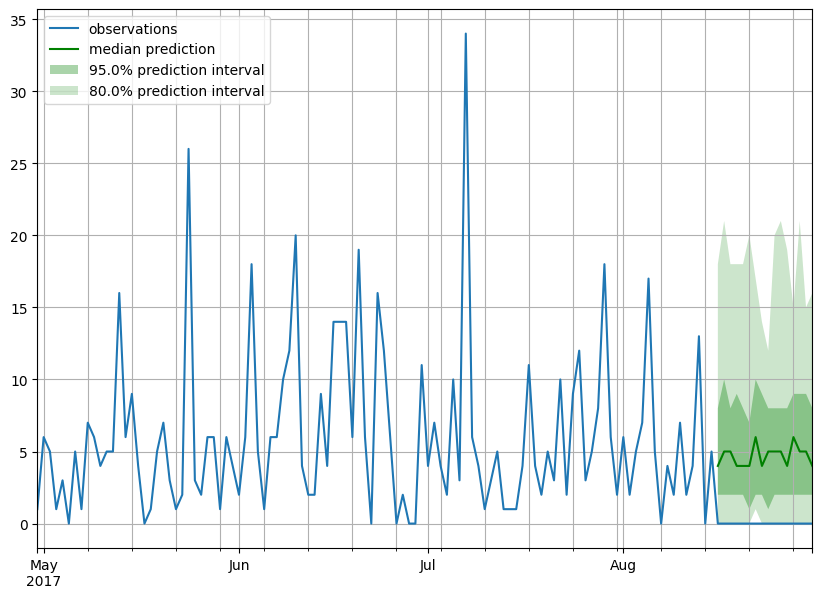

In [ ]:
deepar.prepare_test(date['date_start_test'],date['date_end_test'],'sales','d', cols_dyn_re, cols_stat_cat)
deepar.evaluate(num_samples=100)
deepar.plot_prob_forecasts(5)

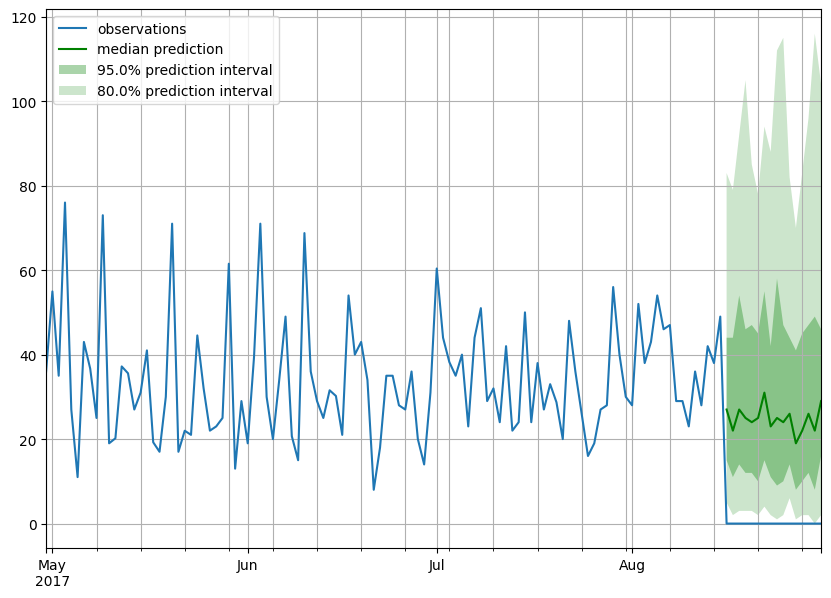

In [ ]:
deepar.plot_prob_forecasts(3)

In [ ]:
y_pred = []
for i in range(len(deepar.forecasts)):
  y_pred.append(deepar.forecasts[i].samples.mean(axis = 0))


In [ ]:
f = prov.first()['dyn_re_id'].reset_index()

In [ ]:
sub = pd.DataFrame(np.concatenate(y_pred))
sub['id'] = f['dyn_re_id']
sub = sub.rename(columns={0:'sales'})
columns_titles = ["id","sales"]
sub=sub.reindex(columns=columns_titles)
sub

,id,sales
0,3000888,1.250000
1,3000889,1.240000
2,3000890,1.500000
3,3000891,1.750000
4,3000892,1.590000
...,...,...
28507,3029263,518.450012
28508,3029264,581.570007
28509,3029265,525.119995
28510,3029266,558.820007


In [ ]:
sub.to_csv(r'gdrive/My Drive/sub.csv', index=False)

In [ ]:
def rmsle(y_pred,y):
  return np.sqrt(np.mean((np.log(y+1)-np.log(y_pred+1))**2))

In [ ]:
y_pred = deepar.forecasts[0].samples.mean(axis = 0)
y_real = np.array(deepar.tss[0]).reshape(-1)[-15:]


print (rmsle(y_pred,y_real))

all_rmsle = []
for i in range(len(deepar.forecasts)):
  y_pred = deepar.forecasts[i].samples.mean(axis = 0)
  y_real = np.array(deepar.tss[i]).reshape(-1)[-15:]
  all_rmsle.append(rmsle(y_pred,y_real))

In [ ]:
plt.hist(all_rmsle)
plt.title(np.round(np.mean(all_rmsle),2))
plt.show()

In [ ]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(deepar.tss, deepar.forecasts)
agg_metrics